<a href="https://colab.research.google.com/github/lucascionis/Colab-Notebooks/blob/main/Simulazione%20scattering%20di%20Rutherford.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Luca Scionis - Università degli Studi di Cagliari**

#Import delle librerie di supporto

Per lo sviluppo delle simulazioni ho fatto affidamento su una serie di librerie molto utilizzate nell'ambito della programmazione python.

Tra queste, le principali sono:



*   **Numpy**: libreria open source che mette a disposizione un gran numero di strumenti per il calcolo con array e matrici;
*   **Scipy**: utilizzata per effettaure il fit dei dati sperimentali con delle curve note;
*   **Matplotlib**: per la visualizzazione dei dati e la creazione di animazioni ho utilizzato matplotlib.

Inoltre, per l'ottimizzazione di alcune parti di codice, ho ritenuto fosse utile ai fini dell'analisi dei tempi della computazione, l'utilizzo della libreria **Numba**. Si tratta di un compilatore **JIT** (just-in-time) che consente di *convertire* il codice python e numpy in linguaggio macchina veloce.

In [ ]:
import time

#Code compiling
import numba as nb
 
#Math libraries
import math
import numpy as np
from numpy.random import default_rng
 
import scipy.constants as const
from scipy.stats import maxwell
from scipy.optimize import curve_fit
 
#Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
 
#Initializing random generator
rng = default_rng()

#Definizione del Velocity Verlet

Per integrare le *equazioni del moto di Newton* ho utilizzato l'algoritmo di integrazione noto come **Velocity Verlet**. L'algoritmo è molto utilizzato nel calcolo delle traiettorie delle particelle nelle simulazioni di dinamica molecolare e in generale nell'ambito della computer grafica (es. motori grafici di gioco).

Il Velocity Verlet rappresenta uno schema molto utilizzato di un altro algoritmo ben noto, ossia il Verlet.

Vediamo come ottenere l'espressione del Verlet dalle espansioni di Taylor:

<p align="center">
$r(t+\varDelta t) =r(t) + v(t)\varDelta t + \frac{a(t)}{2}\varDelta t^2 + \frac{r^{'''}(t)}{6}\varDelta t^3 + O(\varDelta t^4)$
<br>
$r(t-\varDelta t) =r(t) - v(t)\varDelta t + \frac{a(t)}{2}\varDelta t^2 - \frac{r^{'''}(t)}{6}\varDelta t^3 + O(\varDelta t^4)$
</p>

Sommandole si ottiene:

<p align="center">
$r(t+\varDelta t) = 2r(t) - r(t-\varDelta t) + a(t)\varDelta t^2 + O(\varDelta t^4)$
</p>

mentre la velocità viene espressa come:

<p align="center">
$v(t+\varDelta t) = \frac{r(t+\varDelta t)-r(t-\varDelta t)}{2\varDelta t} + O(\varDelta t^2)$
</p>

Si può dimostrare che lo schema seguente, ossia il Velocity Verlet, è equivalente al Verlet:

<p align="center">
$r(t + \varDelta t) = r(t) + v(t)\varDelta t + \frac{1}{2}a(t)\varDelta t^2$ <br>
$v(t+\varDelta t) = v(t) + \frac{a(t) + a(t+\varDelta t)}{2}\varDelta t$
</p>

Quest'ultimo ha i seguenti vantaggi rispetto al Verlet originale:

*   è **self-starting**: non è necessario usare altri algoritmi per inizializzare l'algoritmo; è sufficiente fornire le condizioni iniziali note;
*   **minimizza** l'errore di roundoff: nel Verlet classico la velocità è calcolata come differenza di due quantità dello stesso ordine di grandezza, questo comporta una perdita di precisione; ciò non avviene invece nel Velocity Verlet.

L'implementazione standard dell'algoritmo (in pseudocodice) è la seguente:
```
r(0), v(0), a(0) = condizioni_iniziali()

for i=0 to steps-1
  r(t+dt) = calcola_nuova_posizione(r(t), v(t), a(t), dt)
  a(t+dt) = calcola_forze(r(t))/massa
  v(t+dt) = calcola_nuova_velocità(v(t), a(t), a(t+dt), dt)
```

Di seguito la definizione delle due funzioni base, in python, dell'algoritmo di integrazione del moto:

In [ ]:
@nb.njit
def VV_new_pos(r, v, a, dt):
  return r + v*dt + a * dt**2 *0.5
 
@nb.njit
def VV_new_vel(v, a, a_next, dt):
  return v + (a + a_next) * dt * 0.5

##Considerazioni sull'errore del Verlet

L'algoritmo, come si evince dallo sviluppo in serie di Taylor, presenta un errore locale sulla posizione dell'ordine di $O(\varDelta t^4)$ mentre per la velocità l'errore locale è dell'ordine di $O(\varDelta t^2)$.

Nelle simulazioni di dinamica molecolare, in cui è fondamentale ricavare delle traiettorie che siano le più accurate possibile, bisogna considerare anche il termine di errore globale.

###Errore globale del Verlet: analisi semplificata

Al tempo $t_0+\varDelta t$ l'errore locale sarà

<p align="center">
$errore(r(t_{0}+\varDelta t)) = O(\varDelta t^4)$ù
</p>

dall'espressione della posizione, al tempo $t_0+2\varDelta t$, si ricava:

<p align="center">
$r(t_0+2\varDelta t) = 2r(t_0+\varDelta t) - r(t_0) + a(t+\varDelta t)\varDelta t^2 + O(\varDelta t^4)$
</p>

per cui il termine di errore locale sarà:

<p align="center">
$errore(r(t_{0}+2\varDelta t)) = 2\cdot errore(r(t_{0}+\varDelta t)) + O(\varDelta t^4) = 2\cdot O(\varDelta t^4) + O(\varDelta t^4) = 3\cdot O(\varDelta t^4)$
</p>

procedendo così si può verificare che al tempo $t_0 + 3\varDelta t$, l'errore è:

<p align="center">
$errore(r(t_{0}+3\varDelta t)) = 6\cdot O(\varDelta t^4)$ <br>
$errore(r(t_{0}+4\varDelta t)) = 10\cdot O(\varDelta t^4)$
</p>

in termini generali questo si può esprimere come:

<p align="center">
$errore(r(t_{0}+2\varDelta t)) = \frac{n(n+1)}{2}\cdot O(\varDelta t^4)$
</p>

ponendo $T = n\varDelta t$, e sostituendo nell'espressione sopra, si ottiene:

<p align="center">
$errore(r(t_{0}+2\varDelta t)) = (\frac{T^2}{2 \varDelta t^2} + \frac{T}{2\varDelta t})\cdot O(\varDelta t^4) = \frac{1}{2} \frac{T}{\varDelta t}(\frac{T}{ \varDelta t} + 1)\cdot O(\varDelta t^4) = O(\varDelta t^2)$
</p>

Per cui l'errore **globale** della _posizione_ è dell'ordine di $O(\varDelta t^2)$.

Fonte: https://resources.saylor.org/wwwresources/archived/site/wp-content/uploads/2011/06/MA221-6.1.pdf

#Simulazione Scattering di Rutherford

Lo scattering di Rutherford è un particolare tipo di scattering elastico che vede coinvolte delle particelle cariche. Ciò avviene per via dell'interazione di Coulomb. L'espressione della Forza di Coulomb utilizzata per modellare l'interazione tra le due particelle cariche è la seguente:

<p align="center">
$\textbf{F}_1=\frac{q_1q_2}{4\pi\varepsilon_0}\frac{\textbf{r}}{||\textbf{r}||^3}$ con $\textbf{r} = \textbf{r}_1 - \textbf{r}_2$
</p>

Si tratta della forza sentita dalla carica 1 per effetto della seconda carica. Per la terza legge di Newton varrà: $\textbf{F}_2 = -\textbf{F}_1$.

Attraverso la legge dell'inverso del quadrato applicata alle cariche della particella alpha e al nucleo d'oro si possono fare le seguenti assunzioni:


1.   Non ci sono forze esterne che agiscono sul sistema. Quindi l'energia del sistema è **costante**;
2.   Inizialmente la particella alpha si trova **a grande distanza** dal nucleo dell'atomo d'oro.

Per cui si può ricavare la distanza della particella alpha dal nucleo nel momento in cui tutta l'energia cinetica viene convertita in energia potenziale:
<p align="center">
$\frac{1}{2}mv^2 = \frac{1}{4\pi \varepsilon_0}\cdot\frac{q_1q_2}{r_{min}} \implies r_{min} = \frac{1}{4\pi\varepsilon_0}\cdot\frac{2q_1q_2}{mv^2}$
</p>

##Inizializzazione delle particelle alpha

Per poter eseguire una simulazione con un numero **N** di particelle alpha che diffondono in un atomo d'oro ed ottenere dei risultati, in termini di distribuzione degli angoli di scattering, che fossero coerenti con ciò che la letteratura ha già dimostrato in merito, ho ritenuto opportuno scrivere una funzione che inizializzasse le posizioni delle particelle in una **distribuzione circolare uniforme**.

L'uniformità  è una caratteristica fondamentale se si vuole ottenere una distribuzione delle velocità che segue l'espressione: $\frac{N_0}{\sin^4(\theta)}$.

Distribuzione uniforme di punti in un cerchio: [stackoverflow](https://stackoverflow.com/a/50746409)

In [ ]:
def rnd_coords_in_circle(r, n):
  '''
  r1: radius of circle (centered at the origin)
 
  return: np.array(size=shape) of random x,y coordinates inside
  the circle with radius r
  '''
  #Random angle and radius
  rnd_angle = 2 * np.pi * rng.random(n, dtype=np.float64)
  d = r * np.sqrt(rng.random(n, dtype=np.float64))
 
  #Random coordinates
  x = d * np.cos(rnd_angle, dtype=np.float64)
  y = d * np.sin(rnd_angle, dtype=np.float64)
 
  del rnd_angle
  del d
 
  return x,y

La funzione *init_alpha_particles_3D* si occupa di inizializzare gli array delle posizioni, velocità e forze delle particelle alpha.

In [ ]:
def init_alpha_particles_3D(particles, dist_from_atom, b, init_vel):
  '''
  steps: steps of the simulation
  particles: number of alpha particles
  min_b: minimum impact parameter
  max_b: maximum impact parameter
 
  return: np.arrays of positions and velocities
  '''
  shape = (particles, 3)
  
  r = np.zeros(shape, dtype = np.float64)
  v = np.zeros(shape, dtype = np.float64)
  f = np.zeros(shape, dtype = np.float64)
 
  #Generate random coordinates
  z,y = rnd_coords_in_circle(b, particles)
 
  r[:,0] = dist_from_atom
  r[:,1] = y
  r[:,2] = z
 
  #Assign velocity only on x axis
  v[:,0] = init_vel
 
  del shape
 
  return r,v,f

In questo blocco di codice definisco i parametri costanti di questa simulazione:



*   I numeri atomici **Z1, Z2** rispettivamente di una particella alpha e dell'oro;
*   Il valore della **massa** di una particella alpha;
*   Il termine costante della forza di Coulomb;
*   L'**energia** iniziale associata ad ogni particella della simulazione; di conseguenza anche la **velocità** iniziale;
*   Il valore di r_min (definito precedentemente);



In [ ]:
'''
Z1: alpha particle's atomic number
Z2: gold atom's atomic number
 
F0: Coulomb Force's constant term
'''
Z1, Z2 = 2, 79
alpha_mass = 2 * const.proton_mass + 2 * const.neutron_mass
F0 = Z1 * Z2 * const.e**2/(4 * np.pi * const.epsilon_0 * alpha_mass)

E = 7.75e6 * const.electron_volt  # J
r_min = F0 / E * alpha_mass
alpha_init_vel = np.sqrt(2 * E / alpha_mass)

Definisco in seguito una funzione, *f_coulomb*, per il calcolo della **forza di Coulomb** dato in input un vettore n-dimensionale della distanza. Il vettore d rappresenterebbe la distanza tra due cariche, ma, in questo caso, dato che l'atomo d'oro è posizionato nell'origine, rappresenta direttamente la posizione al tempo t di una particella alpha.

In [ ]:
#Coulomb Force
def f_coulomb(d):
  d_norm = np.linalg.norm(d, axis=1, keepdims=True)

  return F0*d/d_norm**3

Per comprendere meglio come le particelle sono disposte, di seguito vi è un test in cui si inizializzano 1000 particelle in un cerchio di raggio arbitrario posto ad una certa distanza dall'origine, con velocità unitaria.

In [ ]:
r_test,_,_ = init_alpha_particles_3D(1000,
                                    -10,
                                    b = 10,
                                    init_vel = 1)

Come si evince dal plot seguente le particelle si distribuiscono in maniera uniforme nel cerchio; visivamente si nota che non vi sono zono più dense di altre, se non a causa della sovrapposizione di particelle dovuta alla rappresentazione grafica stessa.

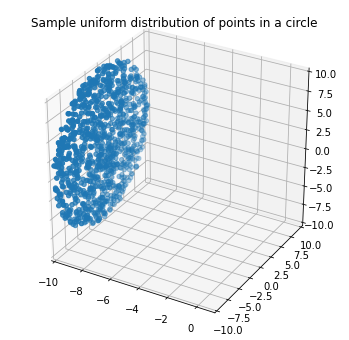

In [ ]:
fig = plt.figure()
 
ax = fig.add_subplot(projection='3d')
ax.set_xlim(-10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
 
ax.set_title("Sample uniform distribution of points in a circle")
ax.scatter(r_test[:,0], r_test[:,1], r_test[:,2])
 
fig.set_size_inches(6,6)
plt.show()

La funzione *calc_angle* permette appunto di calcolare l'angolo tra due vettori. Questa sarà utilizzata per calcolare gli angoli di scattering delle particelle alpha.

In [ ]:
def calc_angle(v1, v2):
  v1_u = np.divide(v1,np.linalg.norm(v1))
  v2_u = np.divide(v2,np.linalg.norm(v2))

  v_dot = np.empty_like(1, dtype=np.float64)
  np.dot(v1_u, v2_u, out=v_dot)

  return  np.arccos(v_dot)

Definisco infine le funzioni che costituiscono il core della simulazione.

La funzione *scattering_update* ricalca fondamentalmente lo pseudocodice dell'algoritmo del Velocity Verlet; richiamo appunto le funzioni definite a inizio del notebook. _VV_new_pos_ e _VV_new_vel_. In questo caso calcolo direttamente le forze senza dividere per la massa; il motivo di ciò è dato dal fatto che ho già messo a denominatore il termine della massa della particella alpha nella costante F0 della forza di Coulomb, per cui non è necessario farlo in questa funzione.

La funzione *scattering_update_tmp* non presenta, nella sua logica di funzionamento, niente di diverso dalla precedente; invece consente di risparmiare memoria RAM, che evidentemente è molto utilizzata, data la quantità di particelle e di steps che devono essere memorizzati. Ai fini del calcolo della distribuzione degli angoli di scattering, non è necessario tenere traccia di tutte le posizioni e di tutte le forze; è sufficiente calcolare ad ogni iterazione i nuovi valori e fare il computo delle velocità, quest'ultime infatti verranno restituite per poter calcolare, attraverso le velocità all'istante 0 e all'istante finale, gli angoli di scattering. Per fare ciò ho utilizzato degli array che contengono solo il valore della grandezza calcolata ad un certo istante e un array temporaneo per conservare un valore ad un istante precedente.

In [ ]:
def scattering_update(r,v,f):
  f[0] = f_coulomb(r[0])
  for t in range(steps-1):
    r[t+1] = VV_new_pos(r[t], v[t], f[t], dt)
    f[t+1] = f_coulomb(r[t+1])
    v[t+1] = VV_new_vel(v[t], f[t], f[t+1], dt)

  return r,v,f

In [ ]:
def scattering_update_tmp(r_0, v_0, f_0):
  tmp = np.zeros(r_0.shape, dtype=np.float64)

  f_0 = f_coulomb(r_0)
  for t in range(steps-1):
    r_0 = VV_new_pos(r_0, v_0, f_0, dt)
    tmp = f_0.copy()
    f_0 = f_coulomb(r_0)
    v_0 = VV_new_vel(v_0, tmp, f_0, dt)

  return v_0

##Commenti sulla gestione della memoria RAM

Una simulazione dello scattering di Rutherford che resituisca dei dati significativi deve essere eseguita con un numero molto elevato di particelle. L'ordine di grandezza del numero di particelle impatta notevolmente sulla quantità di memoria RAM occupata dagli array di inizializzazione. L'utlizzo della funzione *scattering_update_tmp* consente di non utilizzare degli array inizializzati per il numero intero di steps che si vuole simulare, evitando quindi di "riempire" la memoria causando un crash del programma, o dell'intero elaboratore. Vediamo di seguito quanta memoria può occupare un array di numpy al variare del numero di steps e di particelle.

In [ ]:
def get_np_array_size(array, unit):
  '''
  array: np.array
  unit: 0 - bytes, 1 - Kbytes, 2 - Mbytes, 3 - Gbytes

  returns: the size, in gigabytes, of the array
  '''
  array_size = array.size
  array_item_size = array.itemsize

  size = array_size*array_item_size / 10**(unit*3)
  return size

In [ ]:
# 200 steps, 1.000.000 di particelle, 3 dimensioni
shape = (200, int(10e5), 3)
array = np.zeros(shape, dtype=np.float64)

print("La dimensione dell'array, 200 steps e 10e5 particelle, è di {} GB".format(get_np_array_size(array, 3)))

La dimensione dell'array, 200 steps e 10e5 particelle, è di 4.8 GB


Rimuovendo dalla forma dell'array il numero di steps è possibile aumentare l'ordine di grandezza del numero di particelle è la dimensione rimane invariata, 4.8 GB.

In [ ]:
del array

# 10.000.000 di particelle, 3 dimensioni
shape1 = (int(10e6), 3)
array1 = np.zeros(shape, dtype=np.float64)

print("La dimensione dell'array, 0 steps e 10e6 particelle, è di {} GB".format(get_np_array_size(array1, 3)))

La dimensione dell'array, 0 steps e 10e6 particelle, è di 4.8 GB


#Esecuzione dello scattering in 3D

La funzione che si occupa di **eseguire** l'intera simulazione dello scattering in 3D è la seguente, ossia _run_scattering_3D_. La funzione è costituita da una prima istruzione condizionale che, in base al parametro only_angles in input, decide quale delle due funzioni di update richiamare. Come si può notare, nel caso in cui si voglia tenere traccia delle posizioni, delle velocità, delle forze e degli angoli, è necessario inizializzare degli array che hanno come forma: (passi, particelle, dimensione). In questo caso la dimensione è sempre 3, essendo una simulazione in tre dimensioni.

Nel caso in cui non si sia interessati al tracking della traiettoria delle particelle, ma solo alla distribuzione finale degli angoli, è possibile inizializzare gli array di posizione, velocità e forze con la forma **(particelle, dimensione)**.

In [ ]:
def run_scattering_3D(steps, dt, particles, alpha_mass, dist_from_gold, b, init_vel, only_angles):
  '''
  steps: total simulation's steps
  dt: the timestep (time between steps)
  particles: the number of particles
  alpha_mass: alpha particle's mass
  dist_from_gold: the distance, in x axis, of alpha particles from the golden atom
  b: the maximum impact parameter (using rnd circle coordinates it is the radius of the circle)
  init_vel: alpha particles' intial velocity
  only_angles: if true the function only returns the angles otherwise positions, velocities and forces too

  returns: angles only or also positions, velocities and forces
  '''
  
  angles = np.zeros(particles, dtype=np.float64)

  if (not only_angles):
    shape = (steps, particles, 3)

    r = np.zeros(shape, dtype=np.float64)
    v = np.zeros(shape, dtype=np.float64)
    f = np.zeros(shape, dtype=np.float64)
    r[0],v[0],f[0] = init_alpha_particles_3D(particles,
                                            dist_from_gold,
                                            b,
                                            init_vel)
    r,v,f = scattering_update(r,v,f)

    i = 0
    for i in range(particles):
      angles[i] = calc_angle(v[0,i], v[-1,i])

    return r,v,f,angles
  else:
    r_0,v_0,f_0 = init_alpha_particles_3D(particles,
                                          dist_from_gold,
                                          b,
                                          init_vel)

    v_0_s = v_0.copy()

    v_0 = scattering_update_tmp(r_0, v_0, f_0)
 
    i = 0
    for i in range(particles):
      angles[i] = calc_angle(v_0_s[i], v_0[i])
  
    return angles

Per poter eseguire correttamente una simulazione definisco qui il numero di particelle, la distanza dall'atomo d'oro, il timestep, il numero totale di steps e un certo insieme di parametri di impatto.

La formulazione di Rutherfod prevede che le particelle siano poste ad una distanza infinita dall'atomo contro cui si vuole "sparare" il fascio di particelle. Da alcune considerazioni sperimentali fatte con questa simulazione è scaturito che la distanza ottimale per tale per cui si possono considerare abbastanza lontane le particelle alpha dall'atomo d'oro è di circa 100 volte il valore di *r_min*.

Il valore del timestep è stato preso come il rapporto tra r_min e la velocità iniziale delle particelle alpha. Mentre il numero totale di steps è calcolato in modo da far coprire, alle particelle, una distanza pari almeno al doppio della distanza iniziale dall'atomo d'oro.

In [ ]:
particles = int(2e6)
dist_from_gold = -100*r_min
 
#Defining simulation timestep
dt = r_min / alpha_init_vel
 
#Defining number of steps
steps = int(2 * np.abs(dist_from_gold) / r_min)

b = np.array([1, 10, 100, 150]) * r_min

Di seguito vengono eseguite una serie di simulazioni di scattering in cui il numero di particelle simulate aumenta ad ognuna di esse. Viene eseguita una simulazione in cui si tiene traccia delle posizioni e una in cui si restituiscono solo gli angoli di scattering calcolati. Per ogni simulazione si calcola anche il tempo di esecuzione.

In [ ]:
particles_to_track = np.linspace(100, 10e4, 5)

elapsed_time_tracking = np.zeros(particles_to_track.shape)
elapsed_time_no_tracking = np.zeros(particles_to_track.shape)

memory_occupied_tracking = np.zeros(particles_to_track.shape)
memory_occupied_no_tracking = np.zeros(particles_to_track.shape)

for p in range(particles_to_track.shape[0]):
  
  start = timeit.default_timer()
  r,_,_,_= run_scattering_3D(steps, dt, int(particles_to_track[p]), alpha_mass, dist_from_gold, b[0], alpha_init_vel, only_angles = False) 
  elapsed_time_tracking[p] = (timeit.default_timer()-start)*1e3
  memory_occupied_tracking[p] = get_np_array_size(r, 3)

  del r

  start = timeit.default_timer()
  angles = run_scattering_3D(steps, dt, int(particles_to_track[p]), alpha_mass, dist_from_gold, b[0], alpha_init_vel, only_angles = True) 
  elapsed_time_no_tracking[p] = (timeit.default_timer()-start)*1e3
  memory_occupied_no_tracking[p] = get_np_array_size(angles, 3)

  del angles

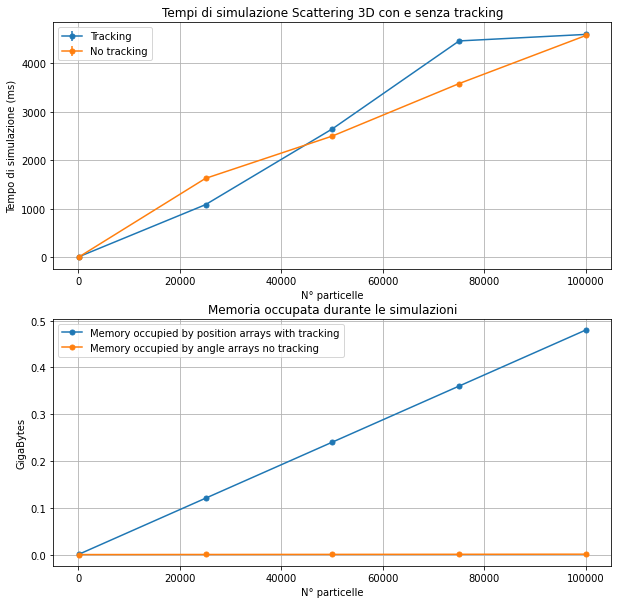

In [ ]:
particles_vs_time_tracking = np.vstack((particles_to_track, elapsed_time_tracking)).T
particles_vs_time_no_tracking = np.vstack((particles_to_track, elapsed_time_no_tracking)).T

particles_vs_memory_tracking = np.vstack((particles_to_track, memory_occupied_tracking)).T
particles_vs_memory_no_tracking = np.vstack((particles_to_track, memory_occupied_no_tracking)).T

fig, (ax, ax1) = plt.subplots(2,1)

ax.errorbar(particles_vs_time_tracking[:, 0], particles_vs_time_tracking[:, 1], yerr=20, marker=".", markersize=10, label = "Tracking")
ax.errorbar(particles_vs_time_no_tracking[:, 0], particles_vs_time_no_tracking[:, 1], yerr=20, marker=".", markersize=10, label="No tracking")

ax.grid()
ax.set_title("Tempi di simulazione Scattering 3D con e senza tracking")
ax.set_xlabel("N° particelle")
ax.set_ylabel("Tempo di simulazione (ms)")
ax.legend()

ax1.plot(particles_vs_memory_tracking[:, 0], particles_vs_memory_tracking[:, 1], marker=".", markersize=10, label="Memory occupied by position arrays with tracking")
ax1.plot(particles_vs_memory_no_tracking[:, 0], particles_vs_memory_no_tracking[:, 1], marker=".", markersize=10, label="Memory occupied by angle arrays no tracking")

ax1.grid()
ax1.set_title("Memoria occupata durante le simulazioni")
ax1.set_xlabel("N° particelle")
ax1.set_ylabel("GigaBytes")
ax1.legend()


fig.set_size_inches(10,10)
plt.show()

Come si evince dal primo grafico non vi è niente che possa indicare che la simualazione senza tracking è più veloce di quella con il tracking delle posizioni. Di fatto, la complessità computazionale è identica per entrambe. Mentre per quanto riguarda la memoria occupata, si può vedere che, per la simulazione con tracking, aumenta linearmente con il numero di particelle. Nella simulazione senza tracking la memoria occupata rimane costante.

#Scattering con tracking delle posizioni

In [ ]:
r,_,_,_= run_scattering_3D(steps,
                           dt,
                           500,
                           alpha_mass,
                           dist_from_gold,
                           b[0],
                           alpha_init_vel,
                           only_angles = False)

##Rappresentazione dello scattering con matplotlib

###Definizione delle funzioni di plot



In [ ]:
def plot_2D_trajectories(r, particles_to_plot):
  fig, ax = plt.subplots()

  if (particles_to_plot > r.shape[1]):
    particles_to_plot = r.shape[1]

  ax.plot(r[:,:particles_to_plot,0],
          r[:,:particles_to_plot,2])
  
  ax.plot(0,0,marker=".")
  
  ax.set_title("Alpha particles trajectories")
  ax.set_xlabel("X axis")
  ax.set_ylabel("Z axis")
  
  ax.grid()
  plt.show()

In [ ]:
def plot_animated_2d_trajectories(r, x_range, y_range, particles_to_plot):
  fig, ax = plt.subplots()

  if (particles_to_plot > r.shape[1]):
    particles_to_plot = r.shape[1]

  ax.axis([x_range, -x_range, -y_range*10, y_range*10])

  ax.set_title("Scattering of {} alpha particles in 3D".format(particles_to_plot))
  ax.set_xlabel("X axis")
  ax.set_ylabel("Z axis")
  ax.grid()

  lines = [ax.plot([], [], [])[0] for particle in range(particles_to_plot)]
  scatter = ax.scatter(0,0,color='orange')
  
  def update(i):
    for p in range(particles_to_plot):
      lines[p].set_data(r[:i, p, 0], r[:i, p, 2])  
  
  anim = FuncAnimation(fig, func=update, frames=steps, interval = 10)

  plt.close("all")

  rc('animation', html='html5')
  return anim

In [ ]:
def plot_3d_animated_trajectories(r, x_range, y_range, particles_to_plot):
  fig = plt.figure()
  ax = fig.gca(projection='3d')

  if (particles_to_plot > r.shape[1]):
    particles_to_plot = r.shape[1]

  ax.axis([x_range, -x_range, -y_range*10, y_range*10])
  ax.set_zlim(-y_range*10, y_range*10)

  ax.set_title("Scattering of {} alpha particles in 3D".format(particles_to_plot))
  ax.set_xlabel("X axis")
  ax.set_ylabel("Y axis")
  ax.set_zlabel("Z axis")

  ax.grid()

  lines = [ax.plot([], [], [])[0] for particle in range(particles_to_plot)]
  scatter = ax.scatter(0,0,color='orange')
  
  def update(i):
    for p in range(particles_to_plot):
      lines[p].set_data(r[:i, p, 0], r[:i, p, 1])
      lines[p].set_3d_properties(r[:i, p, 2])    

  
  anim = FuncAnimation(fig, func=update, frames=steps, interval = 10)

  plt.close('all')

  rc('animation', html='html5')
  return anim

###Plot statici e animati

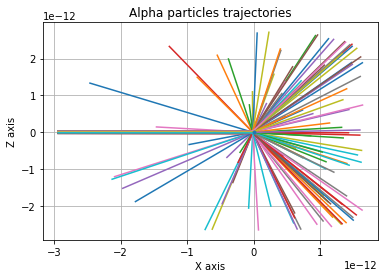

In [ ]:
plot_2D_trajectories(r, 100)

In [ ]:
plot_animated_2d_trajectories(r, dist_from_gold, b[0], 100)

In [ ]:
plot_3d_animated_trajectories(r, dist_from_gold, b[0], 100)

Nelle rappresentazioni sopra, ho scelto un pararmetro di impatto massimo (raggio del cerchio della distribuzione iniziale) pari a $r_{min}$. Per cui gli angoli di scattering, per le particelle che risultano più vicine all'origine del cerchio, vengono diffuse con un angolo maggiore di $90 °$.

#Analisi della distribuzione degli angoli di scattering

Verifico di seguito la distribuzione degli angoli di scattering delle particelle alpha. Secondo la formulazione di Rutherford ci si dovrebbe aspettare una distribuzione che segue la seguente espressione:

<p align="center">
$N(\theta) = \frac{N_0}{\sin^4(\theta/2)}$
</p>

Eseguo una simulazione con i parametri definiti precedentemente, senza tenere traccia delle posizioni delle particelle.

In [ ]:
angles = run_scattering_3D(
    steps,
    dt,
    particles,
    alpha_mass,
    dist_from_gold,
    b[-1],
    alpha_init_vel,
    only_angles = True
  )     

In [ ]:
n_theta = lambda theta, N, alpha: N/np.sin(theta/2)**alpha
n_theta4 = lambda theta, N: n_theta(theta, N, 4)

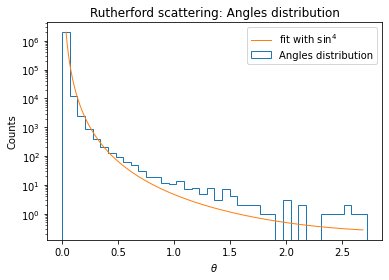

In [ ]:
plt.close('all')

data = angles
fig, ax = plt.subplots()
ax.hist(data, histtype='step', bins = 40, label="Angles distribution")
 
counts, bins = np.histogram(data, bins = 40)
bins = bins[1:] - (bins[1] - bins[0]) / 2

p4, cov4 = curve_fit(n_theta4, bins, counts)

x = np.linspace(bins[0], bins[-1], particles)
y4 = n_theta4(x, p4[0])

p, cov = curve_fit(n_theta, bins, counts, p0=[1, 4])

if not(p[1] < 4 or p[1] >= 4.4):
  print("Fit N and alpha: {},{}".format(p[0], p[1]))
  y = n_theta(x, p[0], p[1])
  label = "a.s. sin^{}".format(math.floor(p[1]))
  ax.plot(x, y, linewidth = 1, label=label)

ax.plot(x, y4, linewidth = 1, label="fit with $\\sin^4$")
ax.set_title("Rutherford scattering: Angles distribution")
ax.set_yscale("log")
ax.set_ylabel("Counts")
ax.set_xlabel("$\\theta$")

ax.legend(loc='upper right')

plt.show()

Come si evince dal grafico sovrastante è possibile eseguire il fit con la forma funzionale desiderata in maniera sufficientemente accurata. All'aumentare dell'angolo theta si nota un aumento dell'errore nel fit; questo probabilmente è dovuto alla distribuzione iniziale delle particelle che può non essere perfettamente regolare, ma potrebbe presentare una densità leggermente maggiore di particelle in un piccolo intorno circolare del centro.

L'accuratezza del fit aumenta all'aumentare del numero di particelle simulate. Di seguito, un'immagine di una simulazione svolta con un numero di particelle pari a 10e6.

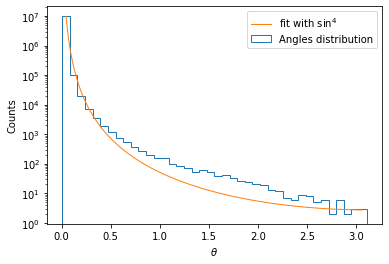

In questo caso è sempre presente una zona compresa tra $\theta = 1.5$ rad e $\theta = 2.5$ rad in cui la distribuzione sperimentale supera la curva del fit. Mentre al di fuori di quel range la curva segue in maniera più accurata l'istogramma.